## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import sklearn
import sklearn.model_selection as skl
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix, accuracy_score 
from random import sample
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import math
import seaborn as sns

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
71443,00017607_000.png,Consolidation|Effusion,0,17607,47,F,PA,2992,2991,0.143000,0.143000,NaN,/data/images_008/images/00017607_000.png
97210,00025640_007.png,No Finding,7,25640,44,F,PA,1940,2021,0.194311,0.194311,NaN,/data/images_011/images/00025640_007.png
51306,00012960_003.png,Emphysema,3,12960,55,M,AP,2500,2048,0.168000,0.168000,NaN,/data/images_006/images/00012960_003.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

all_xray_df.head()

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class']= np.where(all_xray_df ['Pneumonia']==1, 'Pneumonia', 'No_Pneumonia')
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No_Pneumonia
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No_Pneumonia
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No_Pneumonia
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No_Pneumonia
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No_Pneumonia


## Create your training and testing data:

In [5]:
def create_splits(df, test_size, target_columns):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    train_data, val_data = skl.train_test_split(df, 
                                   test_size = test_size, 
                                   stratify = df[target_columns])
    
    p_inds = train_data[train_data.Pneumonia==1].index.tolist()
    np_inds = train_data[train_data.Pneumonia==0].index.tolist()

    np_sample = sample(np_inds, len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]

    p_inds = val_data[val_data.Pneumonia==1].index.tolist()
    np_inds = val_data[val_data.Pneumonia==0].index.tolist()

    # The following code pulls a random sample of non-pneumonia data that's 4 times as big 
    # as the pneumonia sample.
    np_sample = sample(np_inds,4*len(p_inds))
    val_data = val_data.loc[p_inds + np_sample]

    print('split train data cases: ' + str(train_data['Pneumonia'].sum()/len(train_data)))
    
    print('split test data cases: ' + str(val_data['Pneumonia'].sum()/len(val_data)))
    
    return train_data, val_data


In [6]:
train_data, val_data = create_splits(all_xray_df, 0.2, 'Pneumonia')

split train data cases: 0.5
split test data cases: 0.2


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [7]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True , 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range =0.1 , 
                              rotation_range =10 , 
                              shear_range = 0.1,
                              zoom_range=0.1,   
                        )
    
    val_idg = ImageDataGenerator(rescale=1. / 255.0                              
                        )
    
    return train_idg, val_idg


def make_train_gen(train_idg, img_size, train_batch_size):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
     # Todo

    train_gen = train_idg.flow_from_dataframe(dataframe=train_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = img_size, 
                                         batch_size = train_batch_size
                                         )
    return train_gen


def make_val_gen(val_idg, img_size, val_batch_size):
    
    # Todo
    val_gen = val_idg.flow_from_dataframe(dataframe=val_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = img_size, 
                                         batch_size = val_batch_size
                                         )
    return val_gen

In [8]:
img_size = (224,224)
train_batch_size = 32
val_batch_size = 128
train_idg, val_idg = my_image_augmentation()
train_gen = make_train_gen(train_idg,img_size,train_batch_size)
val_gen = make_val_gen(val_idg,img_size,val_batch_size)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [9]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

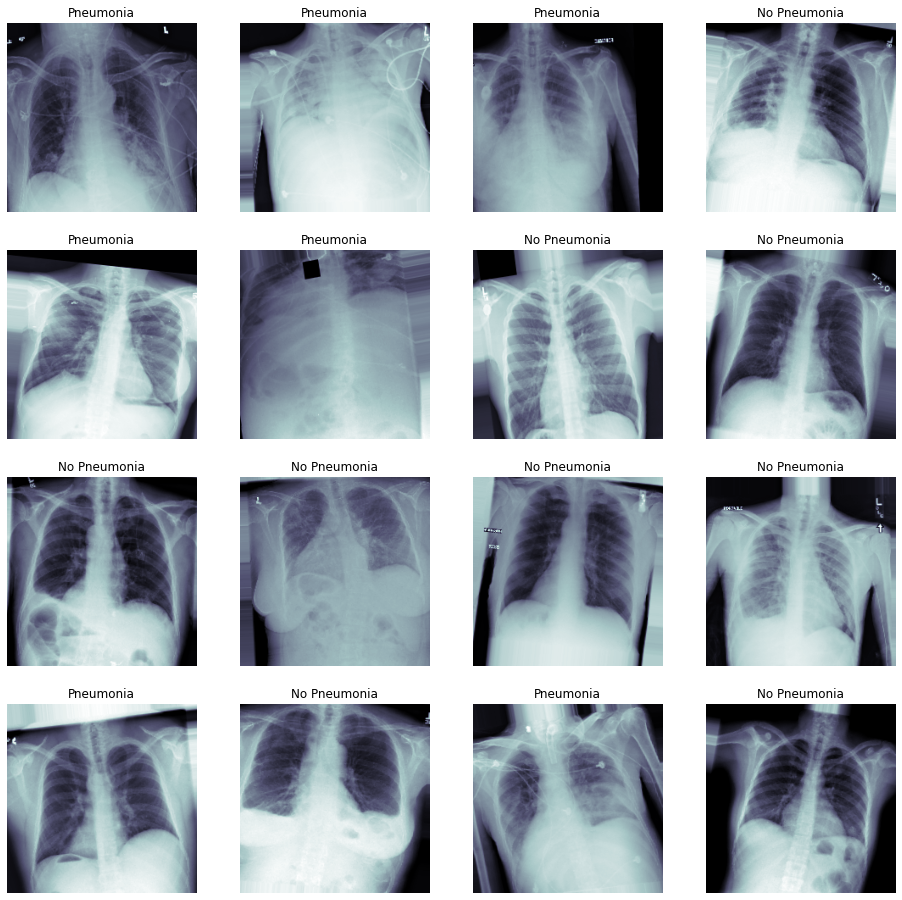

In [10]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [11]:
def load_pretrained_model(pool):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(pool)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    ## choose which layers of VGG16 we actually want to fine-tune
    ## Here, we'll freeze all but the last convolutional layer
    ## and we \freeze all but the last convolutional layer:
    #for layer in vgg_model.layers[0:17]:
    #    layer.trainable = False
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
        
    return vgg_model

vgg_model = load_pretrained_model('block5_pool')
vgg_model


553467904/553467096 [==============================] - 6s 0us/step


In [12]:
def build_my_model(model, dropout):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    my_model = Sequential()
    
    # Add the convolutional part of the VGG16 model from above.
    my_model.add(vgg_model)
    
    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())
    
    my_model.add(Dropout(dropout))
    my_model.add(Dense(1024, activation='relu'))
    
    my_model.add(Dropout(dropout))
    my_model.add(Dense(512, activation='relu'))
    
    my_model.add(Dropout(dropout))
    my_model.add(Dense(256, activation='relu')) 
    
    my_model.add(Dropout(dropout))
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model





## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [13]:
optimizer = Adam(lr=1e-3)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
my_model = build_my_model(vgg_model, 0.5)
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [14]:
for idx, layer in enumerate(my_model.layers):
    print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))

layer 0: model_1, trainable: True
layer 1: flatten_1, trainable: True
layer 2: dropout_1, trainable: True
layer 3: dense_1, trainable: True
layer 4: dropout_2, trainable: True
layer 5: dense_2, trainable: True
layer 6: dropout_3, trainable: True
layer 7: dense_3, trainable: True
layer 8: dropout_4, trainable: True
layer 9: dense_4, trainable: True


In [15]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=15)

callbacks_list = [checkpoint, early]

### Start training! 

In [16]:
## train your model

# Todo

history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 20, 
                          callbacks = callbacks_list)

Epoch 1/20
72/72 [==============================] - 63s 882ms/step - loss: 0.8227 - binary_accuracy: 0.5162 - val_loss: 0.6504 - val_binary_accuracy: 0.6953

Epoch 00001: val_loss improved from inf to 0.65036, saving model to xray_class_my_model.best.hdf5
Epoch 2/20
72/72 [==============================] - 57s 797ms/step - loss: 0.6902 - binary_accuracy: 0.5493 - val_loss: 0.6903 - val_binary_accuracy: 0.5547

Epoch 00002: val_loss did not improve from 0.65036
Epoch 3/20
72/72 [==============================] - 58s 804ms/step - loss: 0.6855 - binary_accuracy: 0.5716 - val_loss: 0.6043 - val_binary_accuracy: 0.6875

Epoch 00003: val_loss improved from 0.65036 to 0.60433, saving model to xray_class_my_model.best.hdf5
Epoch 4/20
72/72 [==============================] - 58s 800ms/step - loss: 0.6841 - binary_accuracy: 0.5729 - val_loss: 0.7249 - val_binary_accuracy: 0.6172

Epoch 00004: val_loss did not improve from 0.60433
Epoch 5/20
72/72 [==============================] - 58s 803ms/step

##### After training for some time, look at the performance of your model by plotting some performance statistics:



In [17]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

128/128 [==============================] - 1s 9ms/step


a good source to read about AUC and ROC Curve: Area Under Curve - Receiver Operating Characteristics

https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
        


In [18]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    ## AUC = Area Under Roc curve
    # t_y == ground truth, p_y == probability/predicted
    # Todo
    
    fig, c_ax = plt.subplots(1, 1, figsize = (9,9))
    fpr,tpr, thresholds = roc_curve(t_y, p_y)
    plt.plot(fpr, tpr, label = '%s (AUC:%0.2f)' %('Pneumonia', auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


## what other performance statistics do you want to include here besides AUC?  
# Todo
def plot_precision_recall_curve(t_y, p_y):
    ## YOUR CODE HERE
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    plt.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    plt.legend()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)    
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Number of Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

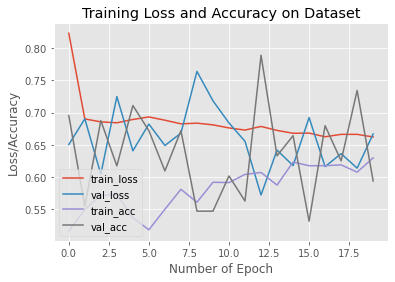

In [19]:
## plot figures

# Todo
plot_history(history)


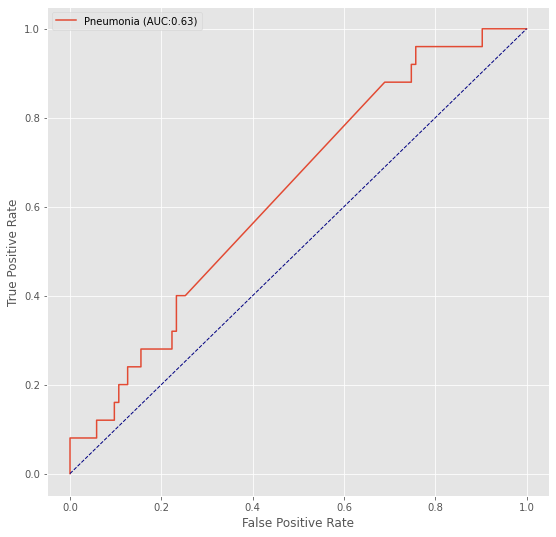

In [20]:
plot_auc(valY,pred_Y)

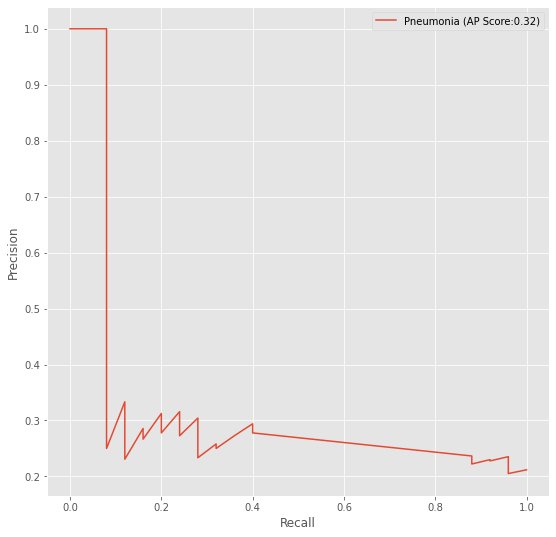

In [21]:
plot_precision_recall_curve(valY,pred_Y)

### Now let us train the model again but with a different learing rate

In [22]:

optimizer = Adam(lr=1e-4)
my_model = build_my_model(vgg_model, 0.5)
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
my_model.summary()
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 20, 
                          callbacks = callbacks_list)



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)              

128/128 [==============================] - 1s 9ms/step


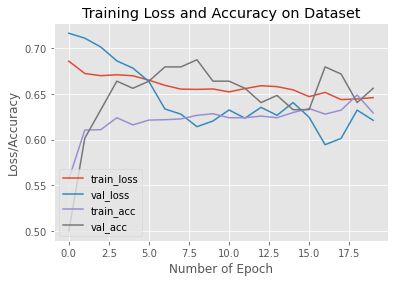

In [23]:
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)
plot_history(history)

In [24]:
optimizer = Adam(lr=1e-6)
my_model = build_my_model(vgg_model, 0.3)
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
my_model.summary()
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 20, 
                          callbacks = callbacks_list)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)              

128/128 [==============================] - 1s 9ms/step


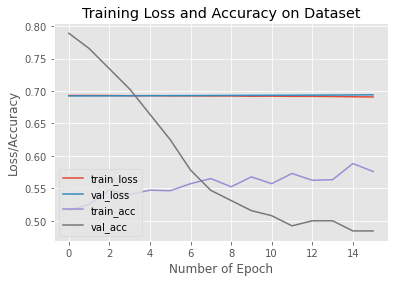

In [25]:
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)
plot_history(history)

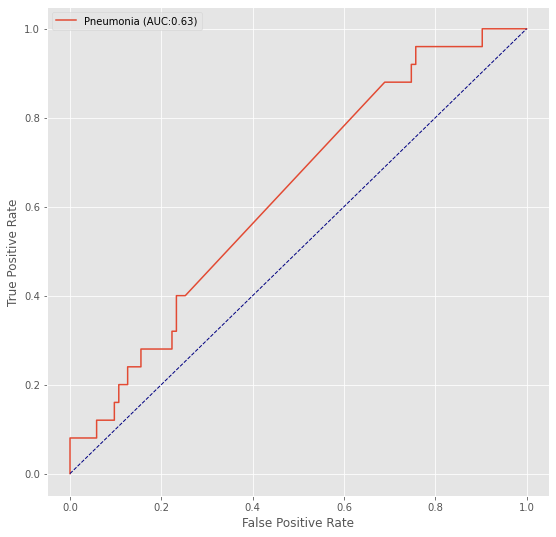

In [26]:
plot_auc(valY,pred_Y)


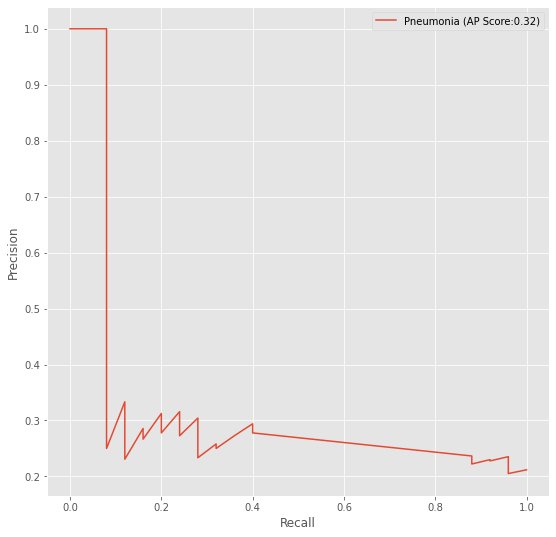

In [27]:
plot_precision_recall_curve(valY,pred_Y)


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [28]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. 
## Make sure you take all your metrics into consideration.

# Todo
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

# Look at the threshold where recall is 0.8
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
prec = precision[idx]*100
rec = recall[idx]*100
tresh = thresholds[idx]*100

f1 = calc_f1(precision[idx],recall[idx])*100

acc = accuracy_score(valY, np.where (pred_Y> round(thresholds[idx], 3), 1,0))*100


print('Precision is: '+ str(prec) +'%')
print('Recall is: '+ str(rec)+'%')
print('Threshold is: '+ str(tresh)+'%')
print('F1 Score is: ' + str(f1)+'%')
print('Accuracy is: ' +str(acc)+'%')






Precision is: 22.22222222222222%
Recall is: 88.0%
Threshold is: 37.581342458724976%
F1 Score is: 35.48387096774193%
Accuracy is: 38.28125%


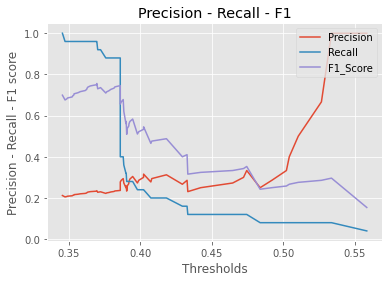

In [29]:
f1_score = calc_f1(precision,recall)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label ='Recall')
plt.plot(thresholds, 2 * f1_score[:-1], label = 'F1_Score')
plt.xlabel('Thresholds')
plt.ylabel('Precision - Recall - F1 score')
plt.title("Precision - Recall - F1")
plt.legend(['Precision', 'Recall', 'F1_Score'], loc='upper right')
plt.show()

TP:  22  - TN:  27  - FP:  76  -FN:  3
Sensitivity = 0.88
Specificity = 0.2621359223300971


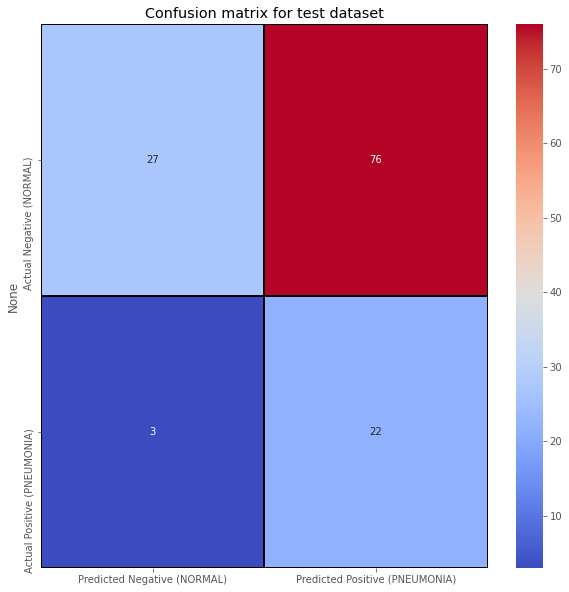

In [30]:
cm = confusion_matrix(valY,  np.where(pred_Y>(thresholds[idx]),1,0))
cm = pd.DataFrame(cm , 
                  index = [['Actual Negative (NORMAL)', 'Actual Positive (PNEUMONIA)']] , 
                  columns = ['Predicted Negative (NORMAL)', 'Predicted Positive (PNEUMONIA)'])

plt.figure(figsize = (10,10))
plt.title('Confusion matrix for test dataset')
plt.xlabel("Predicted")
plt.ylabel("Ground truth")
sns.heatmap(cm,cmap= "coolwarm", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

TP = cm.iloc[1][1]
TN = cm.iloc[0][0]
FP = cm.iloc[0][1]
FN = cm.iloc[1][0]

print('TP: ', TP, ' - TN: ', TN, ' - FP: ', FP, ' -FN: ', FN)

# calculate the sensitivity
sensitivity = (TP / float(TP + FN))
print ('Sensitivity (aka recall) =', sensitivity)
# calculate the specificity
specificity = (TN / float(TN + FP))
print ('Specificity ', specificity)


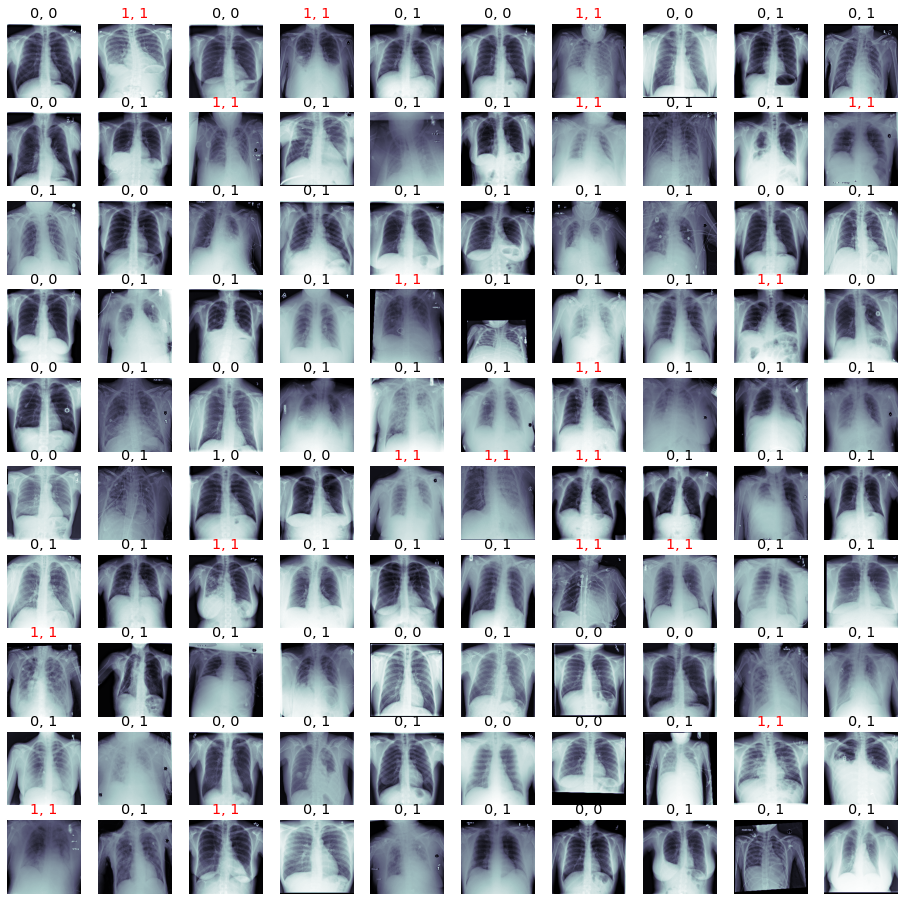

In [31]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > thresholds[idx]:
            
            c_ax.set_title('1, 1',color='red')
            
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > thresholds[idx]: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [32]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)